In [6]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.modules.loss import MSELoss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import tqdm

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create dataset
def sample_X_and_score(gmm, trainN=10000, testN=2000):
  X_train,_,_ = gmm.sample(trainN)
  y_train = gmm.score(X_train)
  X_test,_,_ = gmm.sample(testN)
  y_test = gmm.score(X_test)
  X_train_tsr = torch.tensor(X_train).float()
  y_train_tsr = torch.tensor(y_train).float()
  X_test_tsr = torch.tensor(X_test).float()
  y_test_tsr = torch.tensor(y_test).float()
  return X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr

def sample_X_and_score_t_depend(gmm, trainN=10000, testN=2000, sigma=5, partition=20, EPS=0.02):
  """Uniformly partition [0,1] and sample t from it, and then
  sample x~ p_t(x) and compute \nabla \log p_t(x)
  finally return the dataset x, score, t (train and test)
  """
  trainN_part, testN_part = trainN //partition, testN //partition
  X_train_list, y_train_list, X_test_list, y_test_list, T_train_list, T_test_list = [], [], [], [], [], []
  for t in np.linspace(EPS, 1.0, partition):
    gmm_dif = diffuse_gmm(gmm, t, sigma)
    X_train_tsr, y_train_tsr, X_test_tsr, y_test_tsr = \
      sample_X_and_score(gmm_dif, trainN=trainN_part, testN=testN_part, )
    T_train_tsr, T_test_tsr = t * torch.ones(trainN_part), t * torch.ones(testN_part)
    X_train_list.append(X_train_tsr)
    y_train_list.append(y_train_tsr)
    X_test_list.append(X_test_tsr)
    y_test_list.append(y_test_tsr)
    T_train_list.append(T_train_tsr)
    T_test_list.append(T_test_tsr)
  X_train_tsr = torch.cat(X_train_list, dim=0)
  y_train_tsr = torch.cat(y_train_list, dim=0)
  X_test_tsr = torch.cat(X_test_list, dim=0)
  y_test_tsr = torch.cat(y_test_list, dim=0)
  T_train_tsr = torch.cat(T_train_list, dim=0)
  T_test_tsr = torch.cat(T_test_list, dim=0)
  return X_train_tsr, y_train_tsr, T_train_tsr, X_test_tsr, y_test_tsr, T_test_tsr

# visualization
def kdeplot(pnts, label="", ax=None, titlestr=None, **kwargs):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(x=pnts[:,0], y=pnts[:,1], ax=ax, label=label, **kwargs)
  if titlestr is not None:
    ax.set_title(titlestr)

def visualize_diffusion_distr(x_traj_rev, leftT=0, rightT=-1, explabel=""):
  if rightT == -1:
    rightT = x_traj_rev.shape[2]-1
  figh, axs = plt.subplots(1,2,figsize=[12,6])
  sns.kdeplot(x=x_traj_rev[:,0,leftT], y=x_traj_rev[:,1,leftT], ax=axs[0])
  axs[0].set_title("Density of Gaussian Prior of $x_T$\n before reverse diffusion")
  plt.axis("equal")
  sns.kdeplot(x=x_traj_rev[:,0,rightT], y=x_traj_rev[:,1,rightT], ax=axs[1])
  axs[1].set_title(f"Density of $x_0$ samples after {rightT} step reverse diffusion")
  plt.axis("equal")
  plt.suptitle(explabel)
  return figh

# functions to diffuse and reverse
def marginal_prob_std(t, sigma):
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) )

def marginal_prob_std_np(t, sigma):
  return np.sqrt( (sigma**(2*t) - 1) / 2 / np.log(sigma) )

def diffuse_gmm(gmm, t, sigma):
  beta_t = marginal_prob_std_np(t, sigma)**2 # variance
  noise_cov = np.eye(gmm.dim) * beta_t
  covs_dif = [cov + noise_cov for cov in gmm.covs]
  return GaussianMixture(gmm.mus, covs_dif, gmm.weights)

def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False):
  betaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(betaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        # score_xt = score_model_td(torch.cat((torch.tensor(x_traj_rev[:,:,i-1]).float(),tvec),dim=1)).numpy()
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float(), tvec).numpy()
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev

# Define GaussianMixture class
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    return scores

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

# ScoreModel related
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embed_dim//2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ScoreModel_Time(nn.Module):
  """a time-dependent score-based model"""
  def __init__(self, sigma, ):
    super().__init__()
    self.embed = GaussianFourierProjection(10, scale=1) # t:1 ---> 1x10 vector
    self.net = nn.Sequential(nn.Linear(12, 50),
               nn.Tanh(),
               nn.Linear(50,50),
               nn.Tanh(),
               nn.Linear(50,2)) # 2-> scores of 2 dim
    self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma) # noise_schedule -> sigma^t
      
  def forward(self, x, t): # bs x:(1, 2) t:(1)
      t_embed = self.embed(t)
      pred = self.net(torch.cat((x, t_embed), dim=1)) # channel concat
      pred = pred / self.marginal_prob_std_f(t)[:, None]
      return pred

<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:130: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:130: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3919241/3671404420.py:30: SyntaxWarning: invalid escape sequence '\l'
  """Uniformly partition [0,1] and sample t from it, and then
/tmp/ipykernel_3919241/3671404420.py:130: SyntaxWarning: invalid escape sequence '\l'
  """


# main

In [7]:
# mean and covariance of the 1,2 Gaussian
mu1 = np.array([0,1.0])
Cov1 = np.array([[1.0,0.0], [0.0,1.0]])
mu2 = np.array([2.0,-1.0])
Cov2 = np.array([[2.0,0.5], [0.5,1.0]])

gmm = GaussianMixture([mu1,mu2],[Cov1,Cov2],[1.0,1.0])

sigma = 10
X_train, y_train, T_train, X_test, y_test, T_test = \
  sample_X_and_score_t_depend(gmm, sigma=sigma, trainN=100000, testN=2000, 
                              partition=1000, EPS=0.0001)

score_model_analy = ScoreModel_Time(sigma=sigma, )

# Training loop
optim = Adam(score_model_analy.parameters(), lr=0.001)
loss_fun = MSELoss()
pbar = tqdm.trange(250)
std_vec = marginal_prob_std(T_train, sigma)
for ep in pbar:
  ####### code for prediction and loss caculation
  y_pred = score_model_analy(X_train, T_train)
  loss = torch.mean(torch.sum((y_pred - y_train)**2 * std_vec[:, None], dim=(1)))
  #######
  optim.zero_grad()
  loss.backward()
  optim.step()
  pbar.set_description(f"step {ep} loss {loss.item():.3f}")
  if ep == 0:
    print(f"step {ep} loss {loss.item():.3f}")
  if ep % 25==0:
    y_pred_test = score_model_analy(X_test, T_test)
    loss_test = loss_fun(y_test, y_pred_test)
    print(f"step {ep} test loss {loss.item():.3f}")
    

step 10 loss 0.211:   4%|▍         | 11/250 [00:00<00:04, 52.65it/s]

step 0 loss 0.596
step 0 test loss 0.596


step 35 loss 0.144:  14%|█▎        | 34/250 [00:00<00:04, 50.71it/s]

step 25 test loss 0.170


step 61 loss 0.103:  23%|██▎       | 58/250 [00:01<00:03, 54.31it/s]

step 50 test loss 0.122


step 84 loss 0.070:  34%|███▍      | 85/250 [00:01<00:03, 48.16it/s]

step 75 test loss 0.081


step 110 loss 0.049:  43%|████▎     | 107/250 [00:02<00:02, 49.09it/s]

step 100 test loss 0.055


step 135 loss 0.040:  52%|█████▏    | 131/250 [00:02<00:02, 50.20it/s]

step 125 test loss 0.043


step 160 loss 0.034:  64%|██████▍   | 160/250 [00:03<00:01, 49.51it/s]

step 150 test loss 0.036


step 183 loss 0.029:  74%|███████▎  | 184/250 [00:03<00:01, 47.35it/s]

step 175 test loss 0.031


step 210 loss 0.025:  83%|████████▎ | 207/250 [00:04<00:00, 49.15it/s]

step 200 test loss 0.027


step 235 loss 0.022:  92%|█████████▏| 231/250 [00:04<00:00, 51.82it/s]

step 225 test loss 0.023


step 249 loss 0.021: 100%|██████████| 250/250 [00:04<00:00, 50.58it/s]


In [8]:
#### code for inference
x_traj_rev_analy_pred = reverse_diffusion_time_dep(score_model_analy, sampN=2000, sigma=sigma) # obtain score by NN 神经网络预测的score
x_traj_rev = reverse_diffusion_time_dep(gmm, sampN=2000, sigma=sigma, exact=True) # obtain exact score using score method 用数学公式算出的score

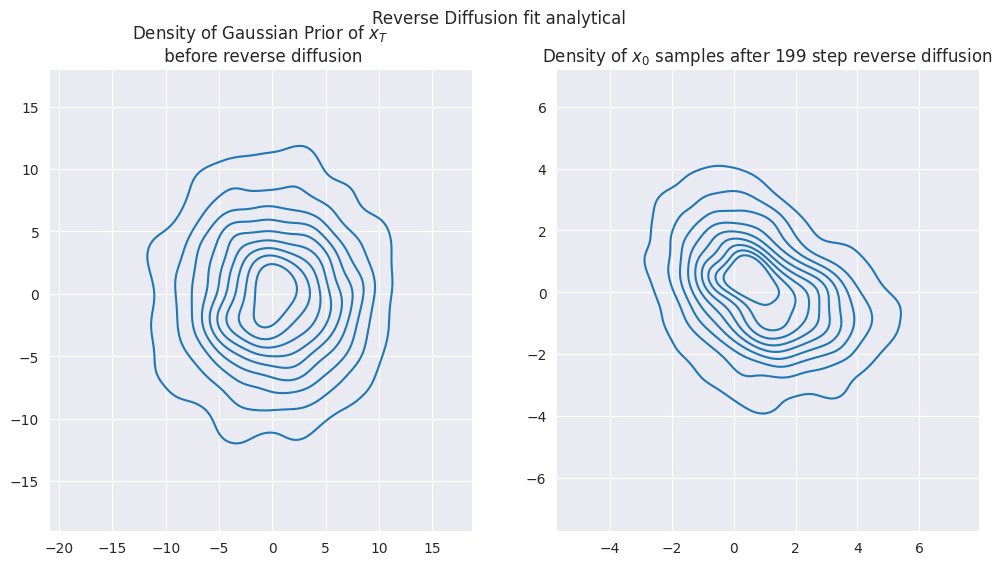

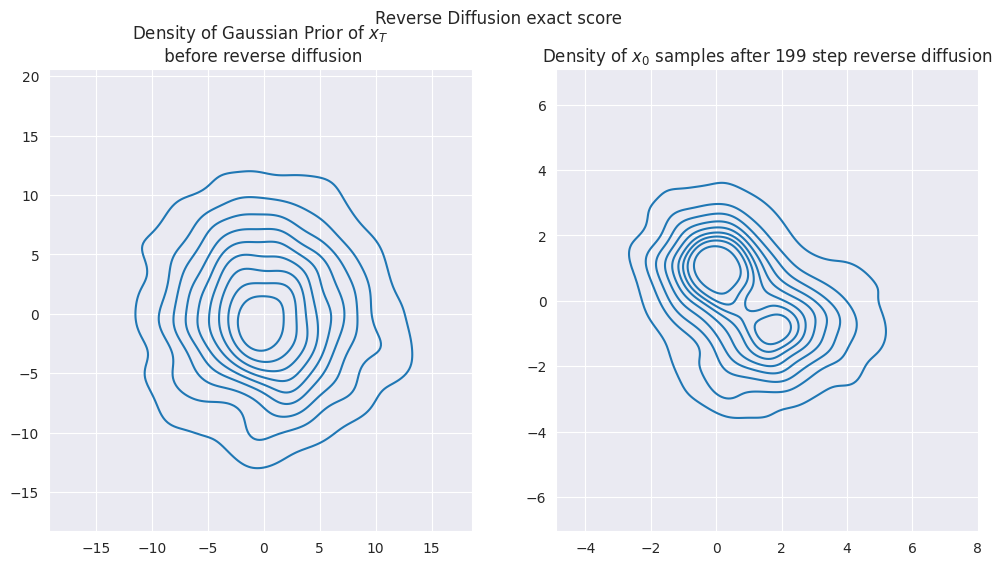

In [9]:
visualize_diffusion_distr(x_traj_rev_analy_pred, explabel="用神经网络预测的");
visualize_diffusion_distr(x_traj_rev, explabel="用数学公式算出的");

/tmp/ipykernel_3919241/4015797569.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


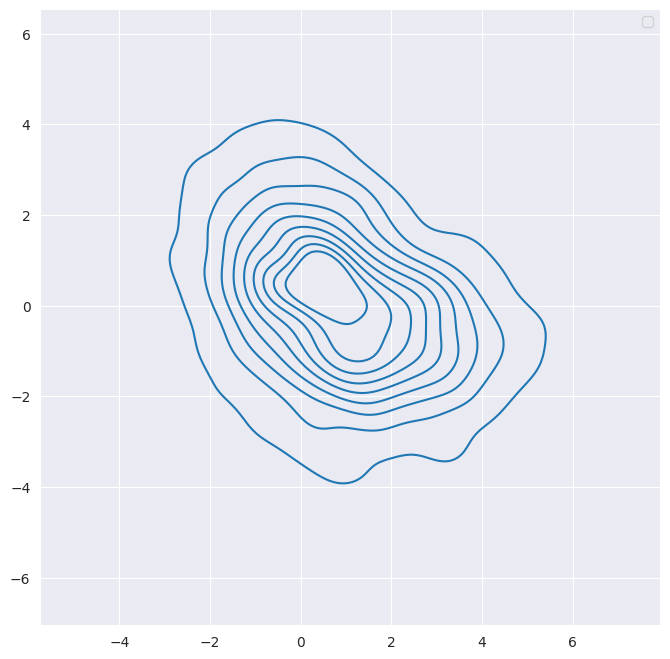

In [10]:
fig,ax = plt.subplots(figsize=[8,8])
kdeplot(x_traj_rev_analy_pred[:,:,-1], "Rev Diff NN T depend t=1.0", )
plt.axis("equal")
plt.legend()

NameError: name 'gmm_samps' is not defined

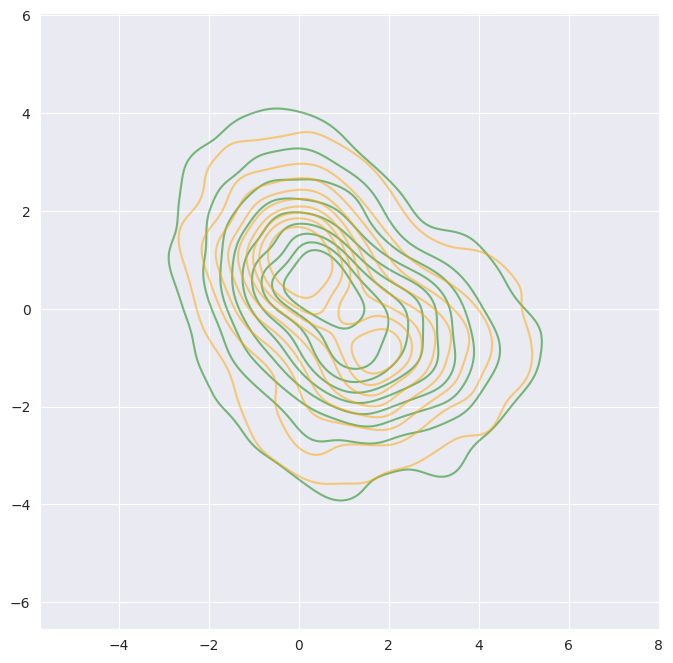

In [11]:
fig, ax = plt.subplots(figsize=[8, 8])

# Plotting
kdeplot(x_traj_rev_analy_pred[:, :, -1], "Rev Diff NN T depend (MSE)", alpha=0.5, color="green")
kdeplot(x_traj_rev[:, :, -1], "Rev Diff (exact score)", alpha=0.5, color="orange") 
kdeplot(gmm_samps, "original GMM sample", alpha=0.5, color="blue")
plt.axis("image")
plt.legend()
plt.show()